# TS-LSTM Model

Reference Article- https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf

Much Better Documentation- https://www.tensorflow.org/tutorials/generative/autoencoder

Phenomenal Interactive Tutorial- https://anomagram.fastforwardlabs.com/#/


- Training the model for +100 Epochs doesn't really seem to add any value to predictive accuracy, keep number of runs over data to min for testing

- Time series is built on top of Gini Coefficients, not on direct volume values -- compare against fourier version of Transformed GCs

- Autoencoders look to reproduce a given $x$ that is pulled from some numeric distribution (in our case daily gini coefficients for stock market volume values)

In [1]:
import os 
import random
import numpy as np 
import time
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# from StockData import * 
from StockDataToGinis import * 

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # tf.keras.utils.set_random_seed(seed) #alt version of tf
    tf.random.set_seed(seed)
    np.random.seed(seed)


In [2]:
# Read in Saved TSVs of Array Data & Reshape

stock_data = "../Data Quality (Stocks)/Stocks_Cleaned.csv"
WINDOW_LEN = 20 #number of days to pull data for (in original random sequence generator), test set size, reshape in MinMaxScaler

X_train = np.loadtxt("autoencoder_data/train.tsv")
X_test = np.loadtxt("autoencoder_data/test.tsv")

# Reshape to fit LSTM Data Schema
X_train = X_train.reshape(9980, 1, 20)
X_test = X_test.reshape(20, 1, 20)

# Get Train & Val Splits
X_val = X_train[-100:] #val needs go first! (train gets reassigned)
X_train = X_train[:-100]


In [3]:
# Normalization -- MinMax Transformation (saving scaler for inverse transform)
from sklearn.preprocessing import MinMaxScaler

# Instantiate Scalers & Fit to Train Set
X_mms = MinMaxScaler()
X_mms.fit(X_train[:, 0, :])

X_train = X_mms.transform(X_train[:, 0, :])
X_train = X_train.reshape((len(X_train), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

X_val = X_mms.transform(X_val[:, 0, :])
X_val = X_val.reshape((len(X_val), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

X_test = X_mms.transform(X_test[:, 0, :])
X_test = X_test.reshape((len(X_test), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input


# Convert ndarrays to tf tensors -- convert either here or in Model Call
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)


# Convert Train & Val Splits into TensorFlow Datasets (easy batch iteration)
batch_size = 10 #good size for this dataset (sufficient updates for time)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train))
train_dataset = train_dataset.shuffle(buffer_size=10000, seed=42).batch(batch_size) #perfect shuffling, will sample from all data points

val_dataset = tf.data.Dataset.from_tensor_slices((X_val))
val_dataset = val_dataset.batch(batch_size)

2022-05-04 07:10:37.993762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Save Randomly Generated Arrays for Model Tests

Used to save a set of generated data, can read in saved arrays with `loadtxt` cell above

In [ ]:
print(X_test.shape)
xt = X_test.reshape(20, 20)
print(xt.shape)

In [23]:
xt.shape #(20, 20)
xt.reshape(20, 1, 20).shape #reshape on entry

(20, 1, 20)

In [20]:
# Write out Train & Test Sets for Eval later (generated randomly, need same data to compare models)

X_train.shape

train = X_train.reshape(9980, 20)
test = X_test.reshape(20, 20)

np.savetxt('autoencoder_data/train.tsv', train, delimiter='    ')
np.savetxt('autoencoder_data/test.tsv', test, delimiter='    ')

In [ ]:
for i, (x) in enumerate(train_dataset):
    print(i, x)

## Define TS-LSTM Architecture

LSTM Layers all the way down? Or should we incorporate a few dense ones? (need roughly same architecture as Linear Autoencoder)

In [9]:
# Autoencoder Architecture
class TS_LSTM(Model):
  @tf.autograph.experimental.do_not_convert
  def __init__(self, latent_large, latent_small):
    super(TS_LSTM, self).__init__()
    self.latent_large = latent_large
    self.latent_small = latent_small
      
    self.encoder = tf.keras.Sequential([
      layers.Dense(20, name="input"), #input layer
      layers.LSTM(latent_large, activation='tanh', name="lstm-1", return_sequences=True, unroll=True), #can convert back into dense layers -- need experiment 
      layers.LSTM(latent_small, activation='tanh', name="lstm-2", return_sequences=True, unroll=True)
                                        ])
    self.decoder = tf.keras.Sequential([
      layers.LSTM(latent_small, activation='tanh', return_sequences=True, name="lstm-3", unroll=True),
      layers.LSTM(latent_large, activation='tanh', return_sequences=True, name="lstm-4", unroll=True),
      layers.Dense(20, activation='tanh') #output effectively (20 value, reconstructed sequence), activation typically used here is sigmoid but relu fits better & tanh fits almost perfect
                                        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




# Root Mean Squared Loss -- Using Keras Provided instead 
def rmse_loss(target_y, predicted_y):
  return tf.matrix_square_root(tf.reduce_mean(tf.square(target_y - predicted_y))) 
  # return tf.reduce_mean(tf.square(target_y - predicted_y)) #original MSE loss function


# Macro Training Func w Batches & Epochs (wraps forward pass/backprop in step)
def train(epochs=int, model=None, save_best=False):
  history = {"train":[], "val":[], "test":[]} #hold eval metrics for plotting
  best_test_acc = 0 #if saving best test set accuracy model weights

  for epoch in range(epochs):
    start_time = time.time()

    # Iter through Batches
    for i, x_batch_training in enumerate(train_dataset):

      loss = train_step(x_batch_training, model)

    train_acc = train_acc_metric.result() #return training results from batches


    # Run Validation Loop per Epoch
    for x_batch_val in val_dataset:
        val_reconstruction = val_step(x_batch_val, model)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()

    # Eval on Test Reconstruction per Epoch
    _, test_acc = reconstruction_accuracy(X_test, model, show=False)

    # Print Accuracies
    print(f"Epoch {epoch} - Time: {(time.time() - start_time):.2f}s")
    print(f"Train: {float(train_acc):.4f} - Val: {float(val_acc):.4f} - Test: {float(test_acc):.4f}\n")

    # Append Results to Dict & Reset Metric States
    history["train"].append(float(train_acc))
    history["val"].append(float(val_acc))
    history["test"].append(float(test_acc))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

    # Save Best Models Weights from Training
    if save_best:
      if best_test_acc <= test_acc:
        model.save('models/TS-LSTM/')
        print("Saved new Best Model")


  history["epochs"] = [i for i in range(0, epochs)] 
  return history


##-- Step Funcs, Static Compiled for 10x Speed Up --##

# Forward & Backward Pass on Model 
@tf.function #decorator does static compiling, 10x faster
@tf.autograph.experimental.do_not_convert
def train_step(x, model):
  with tf.GradientTape() as tape:

    # Forward Pass
    x_reconstruction = model(x)

    # Compute Loss
    loss = loss_fn(x_reconstruction, x)

  # Get Gradients wrt Loss
  grads = tape.gradient(loss, model.trainable_weights)

  # Backprop w Gradient Descent
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  train_acc_metric.update_state(x, x_reconstruction) #update training metric per batch
  return loss

# Validation Step -- compiled for 10x speedup
@tf.function
@tf.autograph.experimental.do_not_convert
def val_step(x, model):
  val_reconstruction = model(x)
  # Update val metrics
  val_acc_metric.update_state(x, val_reconstruction)
  return val_reconstruction


##-- TEST SET EVALUATION FUNCTIONS --##

# Test Reconstruction Accuracy Func -- Gauge Autoencoder performance on a Test Set
def reconstruction_accuracy(test_set, model, show=True):
    # Get Preds for Test
    h = model.encoder(test_set).numpy()
    decoded = model.decoder(h).numpy()

    # Get Error Statistics
    mse = (np.sum(test_set-decoded)**2)/len(decoded)
    mse = float(mse)
    rmse = np.sqrt(mse)
    
    avg_rmse = rmse/len(decoded)

    if show:
        print(f"Total RMSE for Entire Set: {100 * rmse:.2f}%\n  Average RMSE per Example: {100 * avg_rmse:.2f}%")
    else:
        return rmse, avg_rmse

# Plot Sequences from Test Set (Visual Evaluation of Reconstructions)
def plot_reconstruction(model, test_set, indicies):
    # Get Preds
    encoded_data = model.encoder(test_set).numpy()
    decoded_data = model.decoder(encoded_data).numpy()
    
    # Generate Plots
    print("Recreations of Original Signals")
    for i in indicies: #change this for different curves
        x_pred_plot = decoded_data[i]
        x_test_plot = X_test[i].numpy().reshape(-1)

        # Inverse Transform -- need reshape twice, MinMaxScaler expects mulit-dim array & Plotter needs 1d array
        # x_pred_plot = X_mms.inverse_transform(x_pred_plot.reshape(1, 20)).reshape(-1)
        x_pred_plot = x_pred_plot.reshape(1, 20).reshape(-1)

        # x_test_plot = X_mms.inverse_transform(x_test_plot.reshape(1, 20)).reshape(-1) 
        x_test_plot = x_test_plot.reshape(1, 20).reshape(-1)

        # Get Error Statistics
        mse = (np.sum(x_test_plot - x_pred_plot)**2)/len(x_test_plot)
        rmse = float(np.sqrt(mse))

        # Plot Difference Curves
        plt.plot(x_test_plot, "#56B9FF")
        plt.plot(x_pred_plot, '#ABE9B3')
        plt.fill_between(np.arange(20), x_pred_plot, x_test_plot, color='#F28FAD', alpha=0.5)
        plt.legend(labels=["Original", "Reconstructed", "Error"])

        plt.title(f"Index: {i} - RMSE: {100 * rmse:.2f}%")
        plt.xlabel("Time (Days)")
        plt.ylabel("Gini")
        plt.show()

    return




# Instantiate Autoencoder
set_seeds(seed=42)

autoencoder = TS_LSTM(latent_large=50, latent_small=20) #50 & 20 work nicely
optimizer = tf.keras.optimizers.Adam(lr=1e-2) #1e-2
loss_fn = keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss_fn)

# Train & Val Metrics
train_acc_metric = keras.metrics.RootMeanSquaredError()
val_acc_metric = keras.metrics.RootMeanSquaredError()

# Build & Summarize Model
autoencoder.build(input_shape=X_train.shape)
autoencoder.summary()

/Users/ckg-files/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "ts_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (9880, 1, 20)             20300     
                                                                 
 sequential_3 (Sequential)   (9880, 1, 20)             18500     
                                                                 
Total params: 38,800
Trainable params: 38,800
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Run Training

n_epochs = 50
set_seeds() #reproducibility
#(results are reproducible if re-instantiate model with above cell, if re-running training w/o new init, same params get continuously trained)


history = train(n_epochs, autoencoder)

Epoch 0 - Time: 2.26s
Train: 0.1113 - Val: 0.0953 - Test: 0.0104

Epoch 1 - Time: 1.27s
Train: 0.0842 - Val: 0.0778 - Test: 0.0060

Epoch 2 - Time: 1.13s
Train: 0.0727 - Val: 0.0726 - Test: 0.0029

Epoch 3 - Time: 1.31s
Train: 0.0696 - Val: 0.0671 - Test: 0.0053

Epoch 4 - Time: 1.62s
Train: 0.0677 - Val: 0.0628 - Test: 0.0026

Epoch 5 - Time: 1.59s
Train: 0.0647 - Val: 0.0615 - Test: 0.0007

Epoch 6 - Time: 1.42s
Train: 0.0638 - Val: 0.0610 - Test: 0.0093

Epoch 7 - Time: 1.64s
Train: 0.0630 - Val: 0.0608 - Test: 0.0046

Epoch 8 - Time: 1.19s
Train: 0.0603 - Val: 0.0563 - Test: 0.0375

Epoch 9 - Time: 1.27s
Train: 0.0583 - Val: 0.0554 - Test: 0.0235

Epoch 10 - Time: 1.24s
Train: 0.0582 - Val: 0.0541 - Test: 0.0235

Epoch 11 - Time: 1.35s
Train: 0.0551 - Val: 0.0537 - Test: 0.0132

Epoch 12 - Time: 1.50s
Train: 0.0537 - Val: 0.0507 - Test: 0.0122

Epoch 13 - Time: 1.30s
Train: 0.0511 - Val: 0.0491 - Test: 0.0016

Epoch 14 - Time: 1.29s
Train: 0.0501 - Val: 0.0491 - Test: 0.0058

Epoch

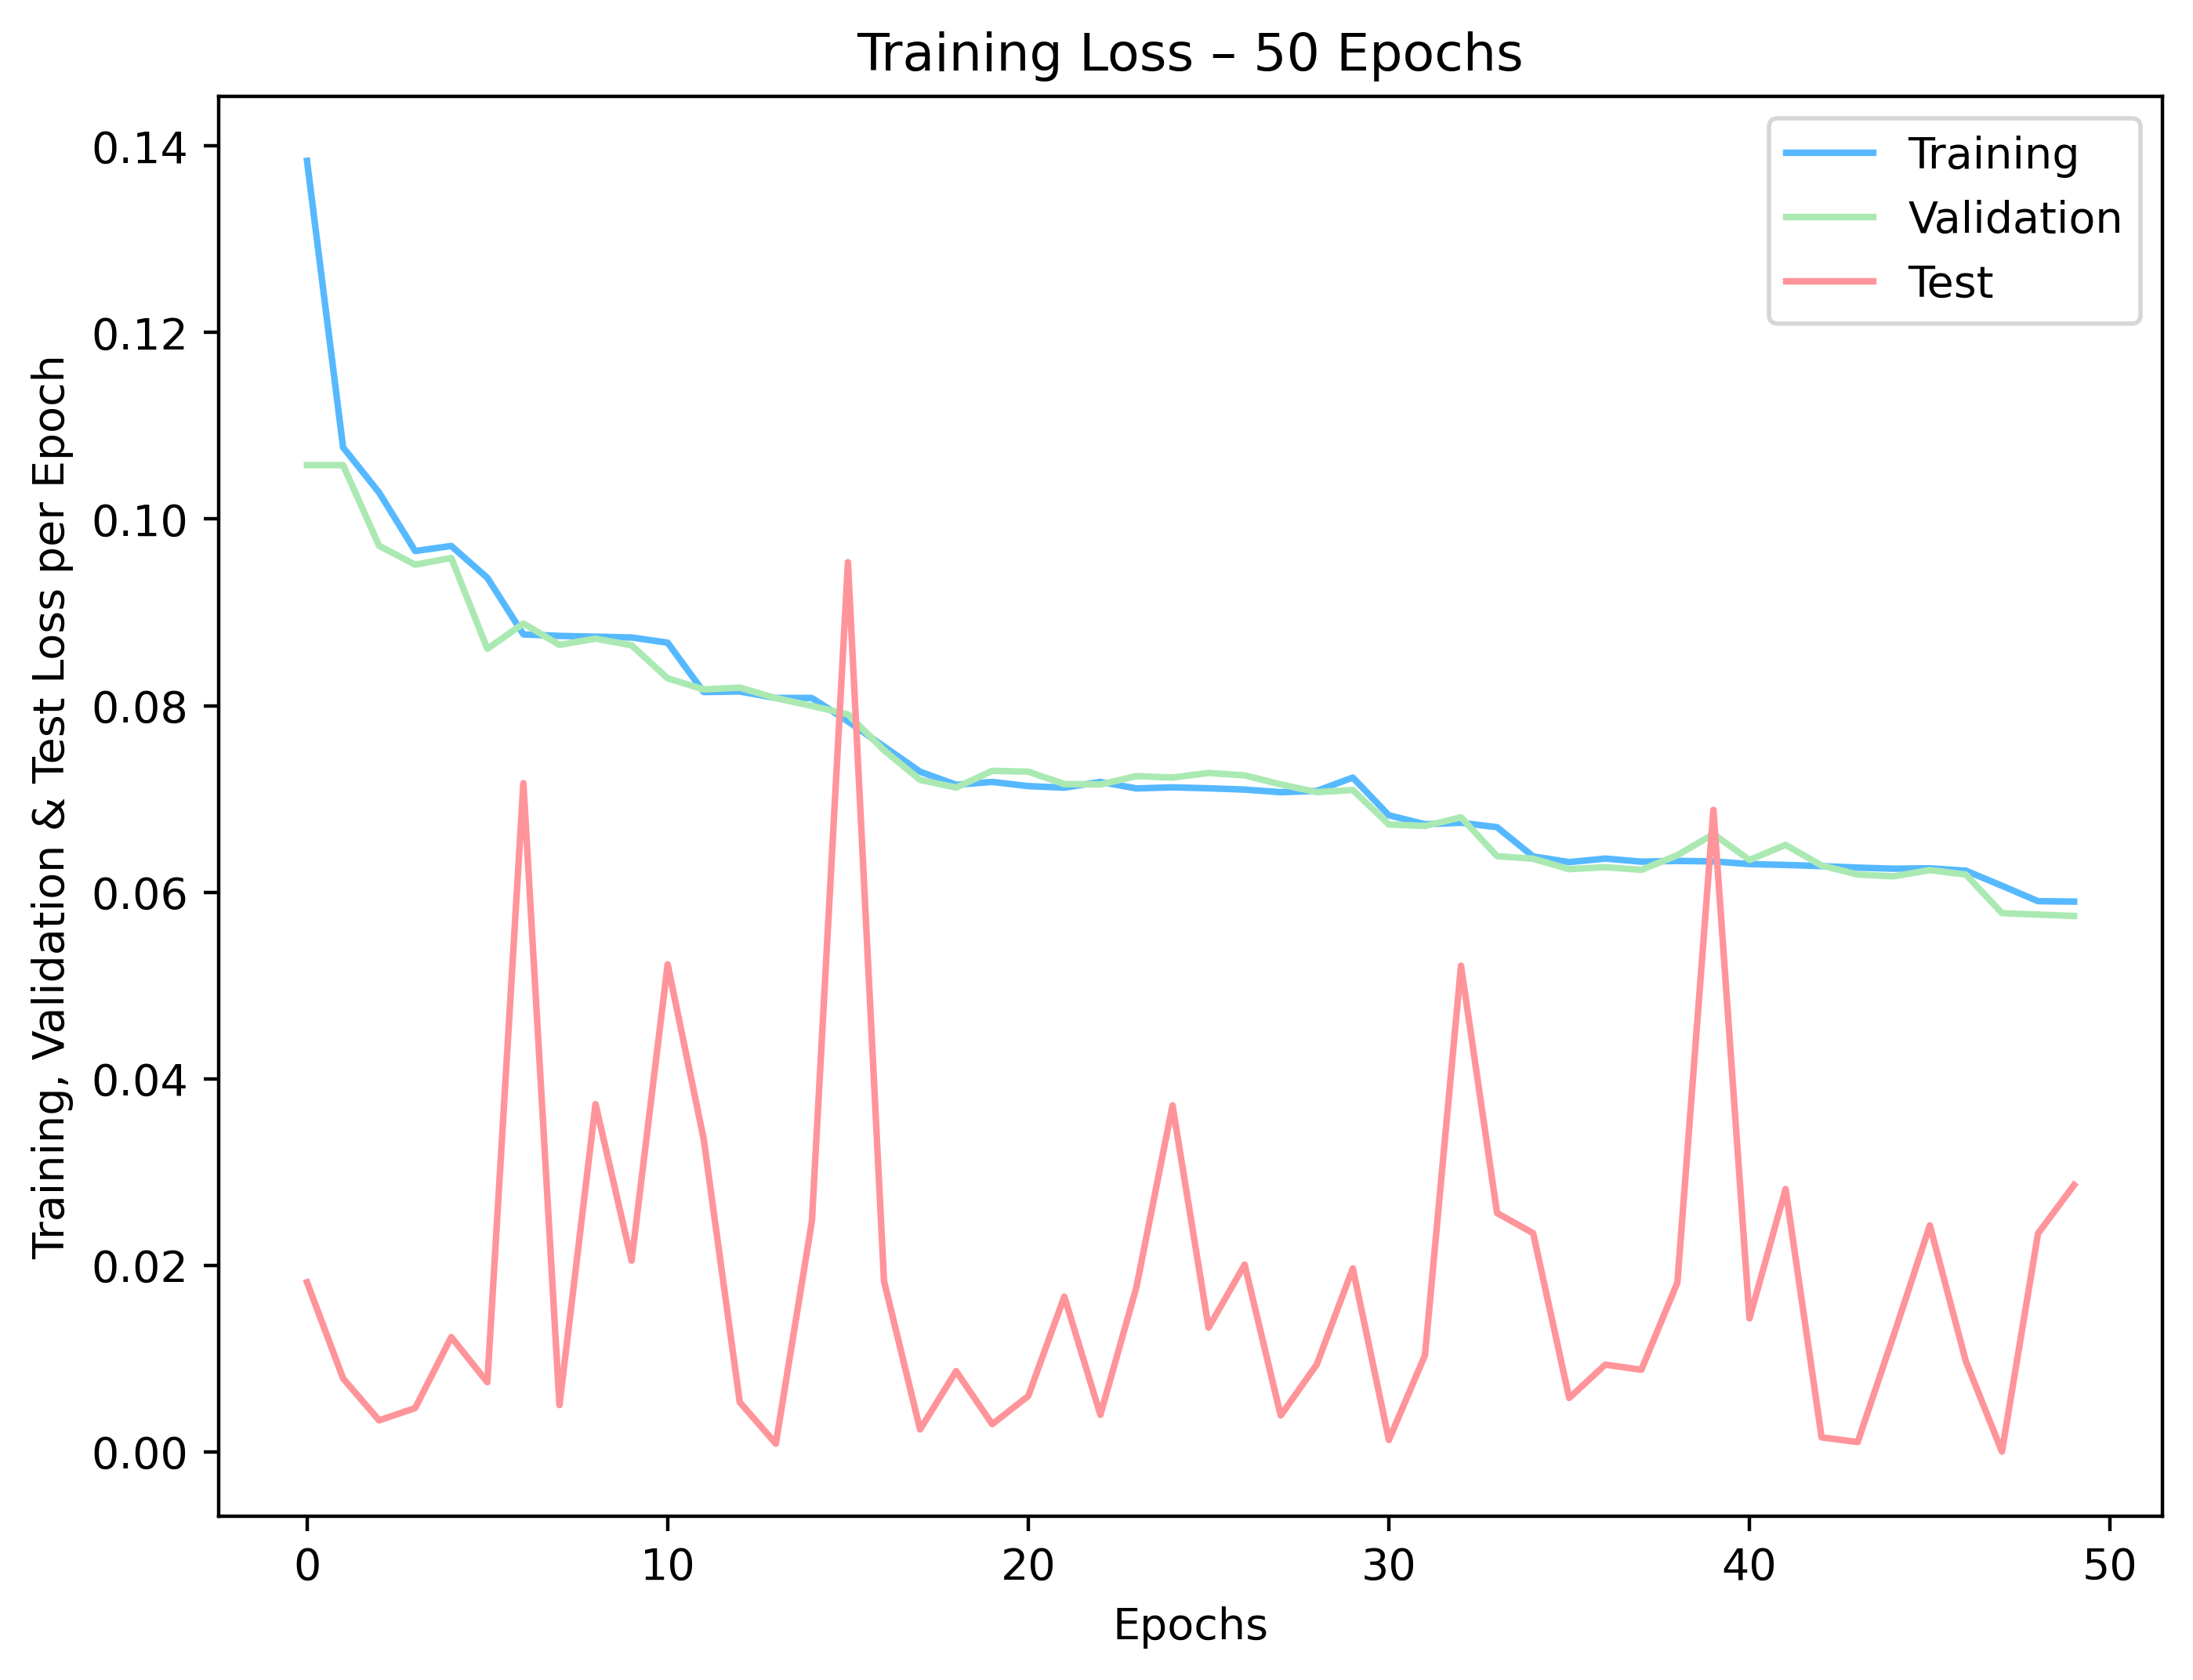

In [6]:
# Plot History from Model Training -- Accuracy 
import matplotlib.pyplot as plt 

plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(8, 6), dpi=400)
plt.title(f"Training Loss – {n_epochs} Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training, Validation & Test Loss per Epoch")

plt.plot(range(n_epochs), history["train"], color="#56B9FF", label="Training")
plt.plot(range(n_epochs), history["val"],   color="#ABE9B3", label="Validation")
plt.plot(range(n_epochs), history["test"],  color="#FF949A", label="Test")
plt.legend(loc="best")



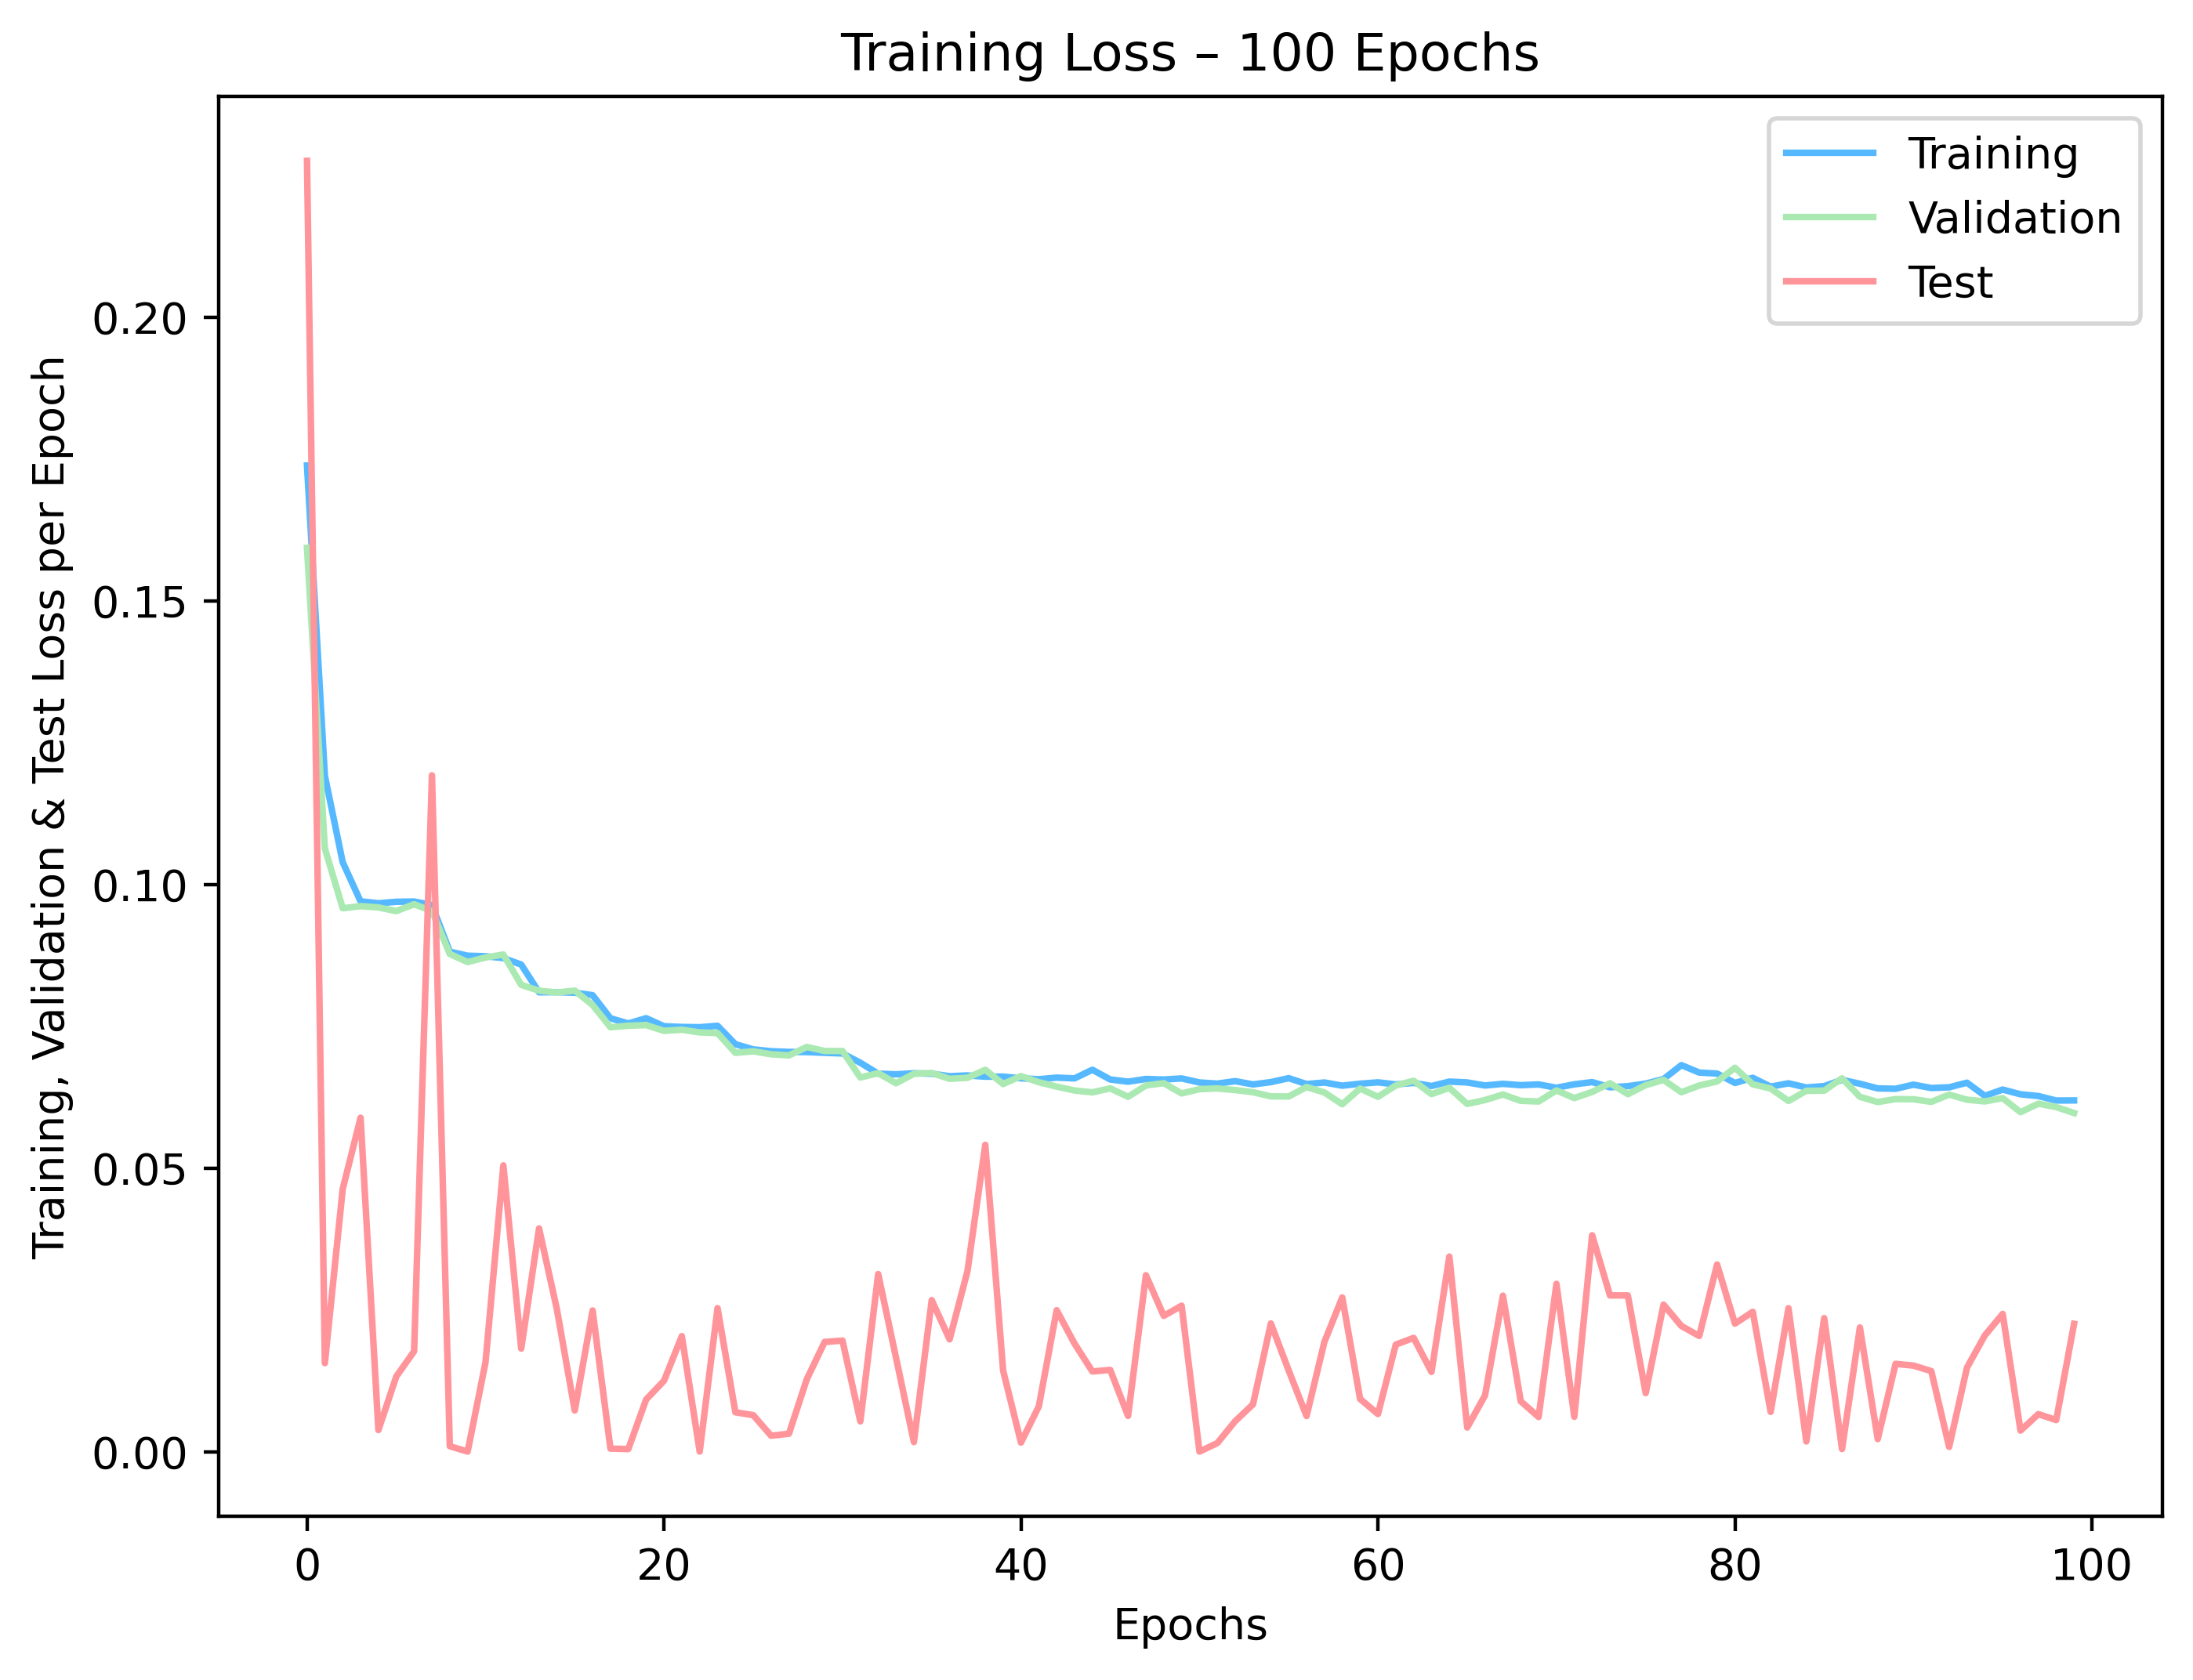

In [20]:
# Plot History from Model Training -- Accuracy 
import matplotlib.pyplot as plt 

plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(8, 6), dpi=400)
plt.title(f"Training Loss – {n_epochs} Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training, Validation & Test Loss per Epoch")

plt.plot(range(n_epochs), history["train"], color="#56B9FF", label="Training")
plt.plot(range(n_epochs), history["val"],   color="#ABE9B3", label="Validation")
plt.plot(range(n_epochs), history["test"],  color="#FF949A", label="Test")
plt.legend(loc="best")



In [11]:
reconstruction_accuracy(X_test, autoencoder) #run pass on test set, get RMSE Accuracy 

Total RMSE for Entire Set: 17.69%
  Average RMSE per Example: 0.88%


In [ ]:
# View Difference Between Recreated & Original Sequences (Single Example)

# Get Preds
encoded_data = autoencoder.encoder(X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# Values to Plot
index_in_test = 1
x_pred_plot = decoded_data[index_in_test]
x_test_plot = X_test[index_in_test].numpy().reshape(-1)


# Inverse Transform -- need reshape twice, MinMaxScaler expects mulit-dim array & Plotter needs 1d array
# x_pred_plot = X_mms.inverse_transform(x_pred_plot.reshape(1, 20)).reshape(-1)
x_pred_plot = x_pred_plot.reshape(1, 20).reshape(-1)

# x_test_plot = X_mms.inverse_transform(x_test_plot.reshape(1, 20)).reshape(-1) 
x_test_plot = x_test_plot.reshape(1, 20).reshape(-1)


# Get Error Statistics
mse = (np.sum(x_test_plot - x_pred_plot)**2)/len(x_test_plot)
rmse = float(np.sqrt(mse))


# Plot Difference Curves
plt.plot(x_test_plot, "#56B9FF")
plt.plot(x_pred_plot, '#ABE9B3')
plt.fill_between(np.arange(20), x_pred_plot, x_test_plot, color='#F28FAD', alpha=0.5)
plt.legend(labels=["Original", "Reconstructed", "Error"])

plt.title(f"{index_in_test} - Recreation of Original Gini Signal - RMSE: {100 * rmse:.2f}%")
plt.xlabel("Trading Days")
plt.ylabel("Gini")
plt.show()

Recreations of Original Signals


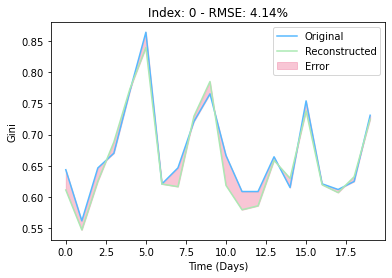

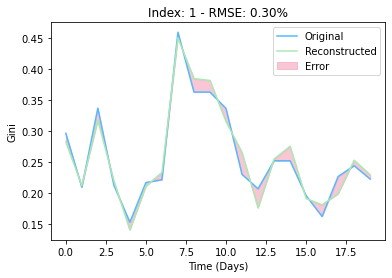

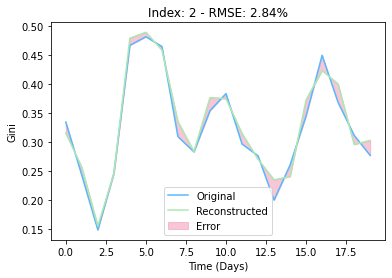

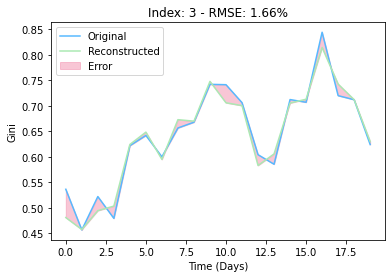

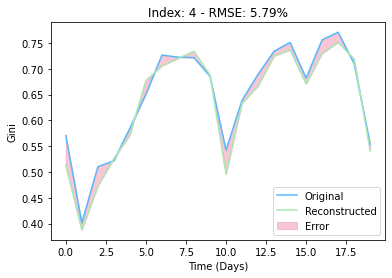

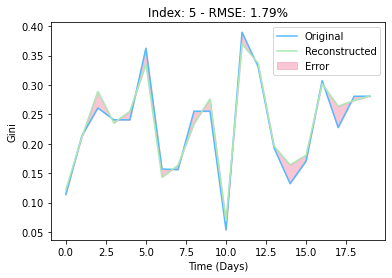

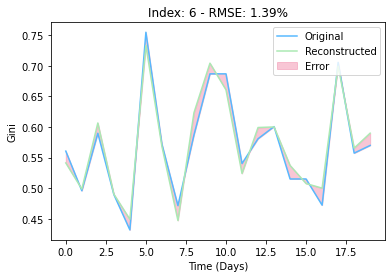

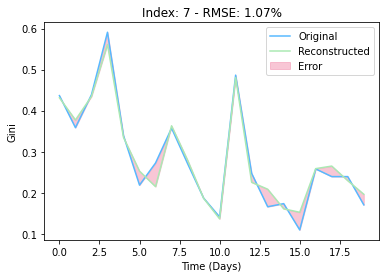

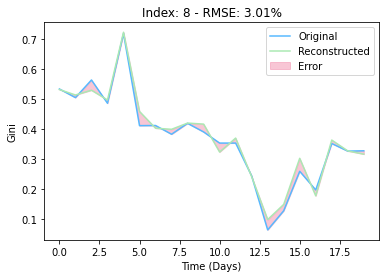

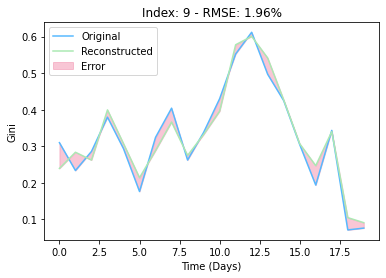

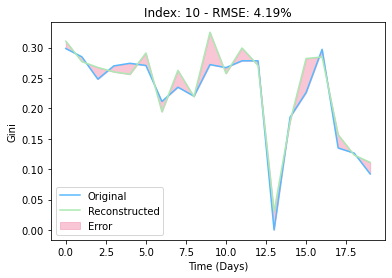

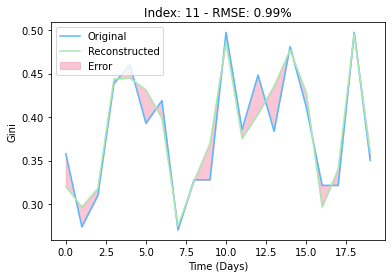

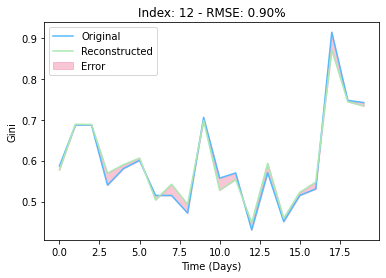

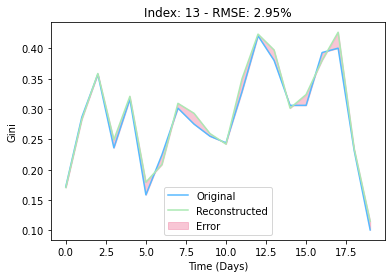

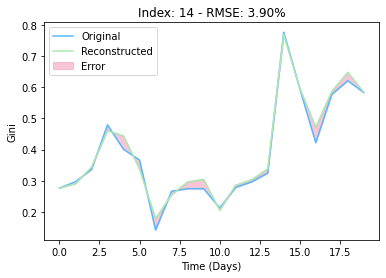

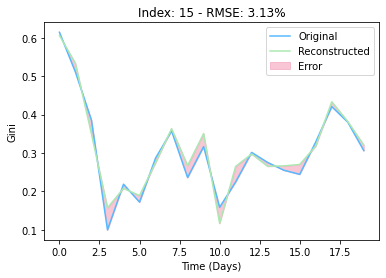

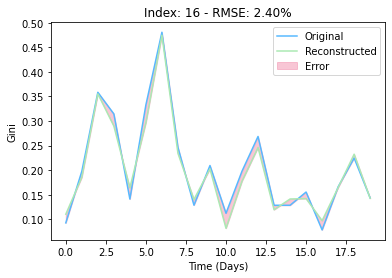

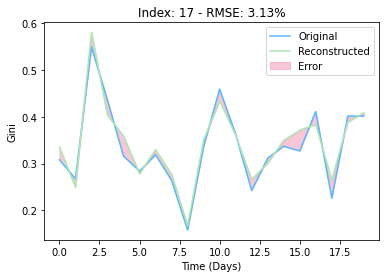

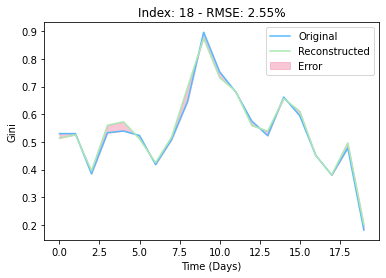

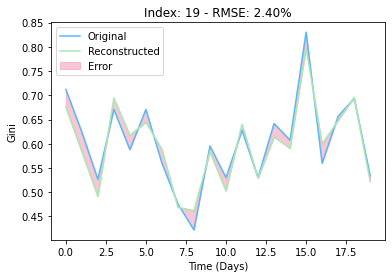

In [15]:
# View Difference Between Sequence (Multi Examples)

plot_reconstruction(autoencoder, X_test, range(0, 20)) #plot all 
# plot_reconstruction(autoencoder, X_test, [0, 3, 7, 9, 12, 16, 19]) #plot specified subset



In [14]:
X_test

<tf.Tensor: shape=(20, 1, 20), dtype=float32, numpy=
array([[[0.64385134, 0.5621277 , 0.646713  , 0.6702679 , 0.7694723 ,
         0.86366636, 0.6211416 , 0.6467844 , 0.72106963, 0.7652006 ,
         0.66662055, 0.6089985 , 0.6089985 , 0.66453695, 0.6153521 ,
         0.7539401 , 0.6213134 , 0.61224943, 0.6251668 , 0.7309332 ]],

       [[0.2959593 , 0.20905165, 0.3365512 , 0.21230683, 0.15267599,
         0.21657999, 0.22116233, 0.45884076, 0.3623952 , 0.3623952 ,
         0.33599404, 0.22980858, 0.20654723, 0.25171968, 0.25171968,
         0.1954584 , 0.16189526, 0.22630596, 0.2437217 , 0.22223184]],

       [[0.33464998, 0.24279378, 0.148587  , 0.246121  , 0.46709546,
         0.48185834, 0.46503794, 0.3095198 , 0.28328025, 0.35427994,
         0.38375223, 0.29682693, 0.27643093, 0.20003855, 0.26053137,
         0.34529206, 0.44984624, 0.36831865, 0.3118826 , 0.27709112]],

       [[0.53663516, 0.45690328, 0.5223158 , 0.47953668, 0.6220643 ,
         0.6420769 , 0.600225  , 0.656762

#### Deprecated Code -- Previous Method

In [ ]:
# Use TS-LSTM to RePredict the Whole Market Data -- Scalar Output
import matplotlib.pyplot as plt
import numpy as np

# Use model to Predict full sequence
y_pred = model.predict(X_total) #returns np.ndarray


# Reshape Arrays
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[2]) #drop 2nd Dimension, no values
y_pred = y_pred.reshape(-1, 1)
yt = y_total.numpy()
yt = yt.reshape(-1, 1)


# Calculate Error -- Showcase in Plot
mse = (np.sum(y_total - y_pred)**2)/len(y_pred)
mse = float(mse)

rmse = np.sqrt(mse)
rmse = float(rmse)

mae = float((np.sum(np.absolute(y_total - y_pred)))/len(y_pred))


# Apply Inverse Transforms (on preds & actual array)
y_pred = y_mms.inverse_transform(y_pred) #both are scaled?
y_pred = y_pred.astype(int)

yt = y_mms.inverse_transform(yt) #both are scaled?
yt = yt.astype(int)


# Plot Market Data Vs. Predicted Movements
plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(12, 8), dpi=400)
plt.title(f"AAPL - Recreation of Original Signal\nErrors– MSE: {100 * mse:.2f}% | RMSE: {100 * rmse:.2f}% | MAE: {100 * mae:.2f}%")
plt.xlabel("Trading Days")
plt.ylabel("Volume")

# plt.plot(range(X_total.shape[0]), y_total, color="#56B9FF", label="Original") #first variation, can del
plt.plot(range(X_total.shape[0]), yt, color="#56B9FF", label="Original")
plt.plot(range(X_total.shape[0]), y_pred,  color="#FF949A", label="TS-LSTM")
plt.legend(loc="best")

In [24]:
X_total.numpy().reshape(1284, 20)

array([[0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       ...,
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045]], dtype=float32)

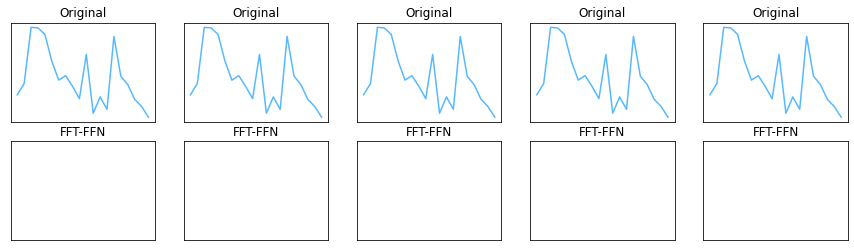

In [96]:
y_pred = model.predict(X_total) #returns np.ndarray

n = 5
plt.figure(figsize=(15, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.plot(X_total.numpy().reshape(1284, 20)[i], color="#56B9FF")
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(y_pred[i],  color="#FF949A")
    plt.title("FFT-FFN")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Plot Loss Distribution - Preds against Actuals
import seaborn as sns 

test_pred = model.predict(X_test)
print(test_pred.shape)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
print(test_pred.shape, y_test.shape)

pred_scores = np.mean(np.abs(test_pred-y_test), axis=1) #calculate difference

# Plotting
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution - Average Absolute Difference', fontsize=16)
sns.distplot(pred_scores, bins=20, kde=True, color='#9994FF');
plt.xlim([0.0,.5])

## Test Misc Functions

In [4]:
# TESTING CELL -- Nonessential
import pandas as pd 

df = pd.read_csv("../Data Quality (Stocks)/Stocks_Cleaned.csv")
df[["date", "volume", "Name"]].set_index("date").loc["2013-02-08"] #example of filtering by datetime index

seq = df[["date", "volume", "Name"]].set_index("date")
seq = df[["date", "volume", "Name"]]
dates_array = df["date"].unique()

In [ ]:
# Save & Load w HDF5 Format -- tossing an error currently, H5 package is too new?
model.save(r'./models/TS-LSTM.h5')

# Read Back in and print Model Schema
m2 = tf.keras.models.load_model('./models/TS-LSTM.h5')
m2.summary()

In [39]:
# Check for Inverse Scaling of Data -- add a return of scaler object (in data read-in) ?

scaler.inverse_transform(y_test)

NameError: name 'scaler' is not defined

In [27]:
history #dict 

{'loss': [0.07760123163461685,
  0.07728737592697144,
  0.07673854380846024,
  0.07617157697677612,
  0.07559974491596222,
  0.07570918649435043,
  0.07473623007535934,
  0.07475299388170242,
  0.07404287159442902,
  0.07454744726419449],
 'val_loss': [0.06179007142782211,
  0.062257975339889526,
  0.061781249940395355,
  0.06358292698860168,
  0.06012799218297005,
  0.06356558948755264,
  0.06544844806194305,
  0.06244674324989319,
  0.06370559334754944,
  0.05944409221410751]}

In [15]:
# fit the model to the data -- Unscaled Test
n_epochs = 3
batch_size = 20
history = model.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/3
48/48 [==============================] - 5s 42ms/step - loss: 59327576.0000 - val_loss: 34600088.0000
Epoch 2/3
48/48 [==============================] - 1s 22ms/step - loss: 59327480.0000 - val_loss: 34598384.0000
Epoch 3/3
48/48 [==============================] - 1s 20ms/step - loss: 58069644.0000 - val_loss: 32728922.0000
